In [73]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utilities.triplet_generator import TripletGenerator
from utilities.mapping import MapFunction 
from utilities import visualization
import keras
from keras import Model
from keras import optimizers
from keras import ops
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer

In [74]:
#HYPERPARAMETERS
image_size = (100, 100)
epochs = 10
batch_size = 8
margin = 1 # margin for triplet loss

In [75]:
# Creating generator

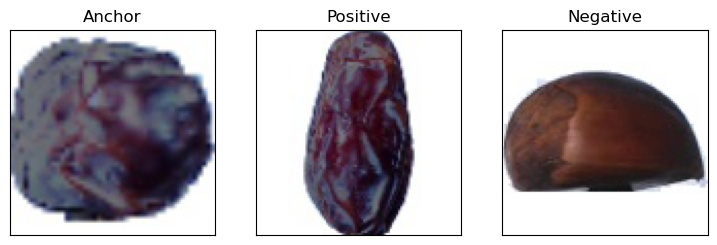

In [76]:
generator = TripletGenerator(r"C:\Users\matim\Documents\Fruits360\archive\fruits-360_dataset\fruits-360\Training")
generator.generate_all_fruits_dict()
photos_generator = generator.get_next_element()
photos = next(photos_generator)
# print(next(photos)[0])
a = mpimg.imread(photos[0])
p = mpimg.imread(photos[1])
n = mpimg.imread(photos[2])

visualization.visualize(a, p, n)

In [77]:
# Creating dataset from generator

In [78]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string)))

In [79]:
print(dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [80]:
# Mapping dataset and separating it into batches

In [81]:
mapped_dataset = dataset.map(lambda anchor, positive, negative: (MapFunction(image_size)(anchor,positive,negative))).batch(batch_size)

In [82]:
print(mapped_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


In [83]:
# Visual verification of images from dataset

8


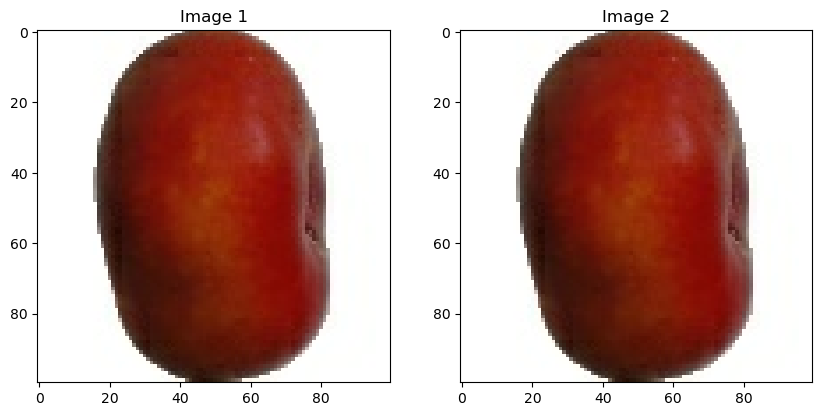

In [84]:
for img1 in mapped_dataset:
    
    plt.figure(figsize=(10, 5))
    # Obraz 1
    plt.subplot(1, 2, 1)
    print(len(img1[0]))
    plt.imshow(np.asarray(img1[0][0]).astype('float32'))
        
    plt.title('Image 1')
    # Obraz 2
    plt.subplot(1, 2, 2)
    plt.imshow(np.asarray(img1[0][0]).astype('float32'))
    plt.title('Image 2')
    plt.show()
    break

In [85]:
# Creating siamese model

In [86]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input_layer, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu



In [87]:
# Function to calculate the distances of embeddings 

In [88]:
def distance(anchor, positive, negative):
    ap_distance = ops.sum(tf.square(anchor - positive), -1)
    an_distance = ops.sum(tf.square(anchor - negative), -1)
    return ap_distance, an_distance

In [89]:
# Adding merge layer and creating output layer

In [90]:
anchor_input = keras.layers.Input(name="anchor", shape=(100,100,3))
positive_input = keras.layers.Input(name="positive", shape=(100,100,3))
negative_input = keras.layers.Input(name="negative", shape=(100,100,3))

# distances = DistanceLayer()(
#     embedding_model(anchor_input),
#     embedding_model(positive_input),
#     embedding_model(negative_input),
# )
tower_1 = embedding_network(anchor_input)
tower_2 = embedding_network(positive_input)
tower_3 = embedding_network(negative_input)

merge_layer = keras.layers.Lambda(distance, output_shape=(1,))([tower_1, tower_2, tower_3])
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=output_layer)


In [91]:
# Triplet Loss function 

In [92]:
def loss_wrapper(margin=1):
    """
    Arguments: 
        margin: Integer, defines the baseline for distance for which pairs
        shoud be classified as dissimilar "1"
    Returns:
        tensor with contrastive loss as floating point value
    """
    # 0-same ,  1-different
    
    #contrastive_loss = (1-y_true)*

    def triplet_loss(self, ap_distance, an_distance):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        # ap_distance, an_distance = siamese_network(data)
    
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    return triplet_loss


In [93]:
# Compilation of our model and summary

In [94]:
# siamese_model = SiameseModel(siamese_network)
siamese_network.compile(loss=loss_wrapper(margin=margin),optimizer=optimizers.Adam(0.0001), metrics=["accuracy"])
siamese_network.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 100, 100,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_13       │ (None, 10)        │    230,902 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ functional_13[0]… │
│                     │                   │            │ functional_13[1]… │
│                     │                   │            │ functional_13[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 230,908 (901.98 KB)

 Trainable params: 199,924 (780.95 KB)

 Non-trainable params: 30,984 (121.03 KB)

In [95]:
# Training 

In [96]:
siamese_network.fit(mapped_dataset, epochs=epochs, batch_size=batch_size)

Epoch 1/10


ValueError: Layer 'functional_15' expected 3 input(s). Received 1 instead.